# SEGMENT GPS Analysis

##### Notes
UTM  36North
EPSG:32636

In [29]:
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import numpy as np
import os

import pandas as pd
import geopandas as gpd

import gpstools as gps

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

#from cartopy.io import LocatedImage
#from cartopy.io.shapereader import Reader
from cartopy.io.img_tiles import MapboxTiles

import warnings; warnings.simplefilter('ignore')

In [2]:
### 31 Dec. 2014 Mw 5.1 
pSegment = np.array([33.8451, -9.86088]) 
pNEIC = np.array([33.863, -10.027]) 
pCMT = np.array([33.79, -9.73]) 

In [3]:
%matplotlib inline
%qtconsole
plt.style.use('seaborn-white')
plt.rcParams['font.size'] = 16

In [4]:
dfM = gps.io.ungl.load_midas()

In [5]:
dfM.head()

,site,version,start,end,years,epochs,epochs_good,pairs,east,north,...,e0,n0,u0,out_e,out_n,out_u,sig_e,sig_n,sig_u,nsteps
0,00NA,MIDAS4,2008.2355,2017.0568,8.8213,2645,2645,4750,35.845,58.510,...,-0.342,1.148,14.499,0.074,0.089,0.091,2.966,3.240,9.275,0
1,01NA,MIDAS4,2008.2683,2017.0568,8.7885,1585,1585,2813,35.493,59.453,...,0.676,2.161,-15.470,0.110,0.114,0.120,2.273,2.105,7.488,0
2,02NA,MIDAS4,2008.7255,2016.9993,8.2738,1906,1906,3378,35.889,59.791,...,-4.092,1.212,-6.671,0.087,0.073,0.081,2.503,2.768,8.395,0
3,1LSU,MIDAS4,2003.3073,2016.5749,13.2676,4339,3986,5213,-12.547,-0.285,...,1.566,-4.303,-10.141,0.054,0.062,0.070,4.197,3.199,9.805,5
4,1NSU,MIDAS4,2004.0411,2017.0568,13.0157,4314,4258,6487,-13.256,-0.224,...,-2.532,1.352,0.951,0.069,0.056,0.056,2.335,2.328,9.035,2


In [6]:
dfM.keys()

Index(['site', 'version', 'start', 'end', 'years', 'epochs', 'epochs_good',
       'pairs', 'east', 'north', 'up', 'err_e', 'err_n', 'err_u', 'e0', 'n0',
       'u0', 'out_e', 'out_n', 'out_u', 'sig_e', 'sig_n', 'sig_u', 'nsteps'],
      dtype='object')

In [8]:
dfS = gps.io.ungl.load_stations()

In [9]:
dfS.head()

,site,lat,lon,height,start,end
0,00NA,-12.4666,130.8440,104.851,2008-03-27,2017-01-21
1,01NA,-12.4782,130.9820,105.409,2008-04-08,2017-01-21
2,02NA,-12.3559,130.8817,117.652,2008-09-22,2016-12-31
3,1LSU,30.4074,-91.1803,-6.487,2003-04-23,2016-07-29
4,1NSU,31.7508,-93.0976,28.071,2004-01-16,2017-01-21


## Extract Station between certain lat-lon range

In [10]:
subset = dfS.query('(-16 < lat < -6) and (30 < lon < 40)') #Extend East to get subandes stations
df = pd.merge(dfM, subset, how='inner', on=['site'])
# Additional subset to get same time range as PLUTONS stations
#df.query('(start >= 2010.2861) and (end <= 2015.1951)') #UTUR
# Doesn't work,,, for interseismic analysis consider UTUR start up to Pisagua EQ, however, MIDAS
# supposedly is insensitive to offsets, or actually removes them based on events in steps database

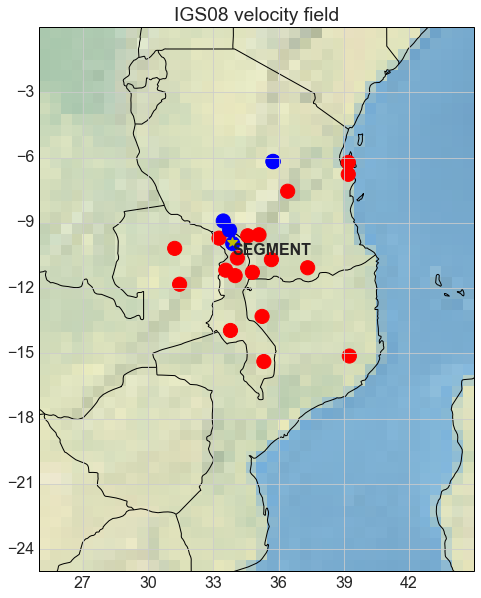

In [44]:
# Basic Map
plot_CRS = ccrs.PlateCarree()
geodetic_CRS = ccrs.Geodetic()

#x0, y0 = plot_CRS.transform_point(28, -18, geodetic_CRS)
#x1, y1 = plot_CRS.transform_point(42, -4, geodetic_CRS)
#fig,ax = plt.subplots(figsize=(8,8), dpi=100, 
#                      subplot_kw=dict(projection=plot_CRS))
#ax.set_xlim((x0, x1))
#ax.set_ylim((y0, y1))

fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection=plot_CRS)
ax.set_extent([25, 45, 0, -25]) #W E N S 

ax.stock_img() # very low-res, but fast!

sc = plt.scatter(df.lon, df.lat, c=df.up*1e3, s=200, 
                 norm=None,
                 vmin=-5,
                 vmax=5,
                 cmap=plt.cm.bwr, #linear scale 
                 #cmap=plt.cm.bwr, #symmetric scale
                 transform=geodetic_CRS,
                 zorder=2,
                 )

# Plot seismic epicenters
plt.plot(*pSegment, 'y*', ms=10, transform=ccrs.Geodetic())
plt.annotate('SEGMENT', pSegment, (1, -1), transform=ccrs.Geodetic(), fontweight='bold', va='top',zorder=10, textcoords='offset points')

#plt.plot(*pNEIC, 'm*', ms=10, transform=ccrs.Geodetic())
#plt.annotate('NEIC', pNEIC, transform=ccrs.Geodetic(), fontweight='bold', ha='center', va='top', zorder=10)

#plt.plot(*pCMT, 'c*', ms=10, transform=ccrs.Geodetic())
#plt.annotate('CMT', pCMT, transform=ccrs.Geodetic(), fontweight='bold', ha='center', va='top', zorder=10)

# Plot trench

# Could plot far-field subset or scale vectors close to EQ by 1/2...
#Q = plt.quiver(df.lon, df.lat, df.east, df.north, scale=100, color='k', zorder=1) # bigger arrows
#qk = plt.quiverkey(Q, 0.2, 0.1, 10, '10 mm', labelpos='N',coordinates='axes')

#cb = plt.colorbar(sc, orientation='vertical', shrink=0.7)
#cb.set_label('du [mm]')

ax.coastlines('50m')

borders = cfeature.BORDERS
borders.scale='50m'
ax.add_feature(borders)

gl = ax.gridlines(draw_labels=True)
gl.xlabels_top = False
gl.ylabels_right = False

plt.title('IGS08 velocity field')

Number of Stations =  23


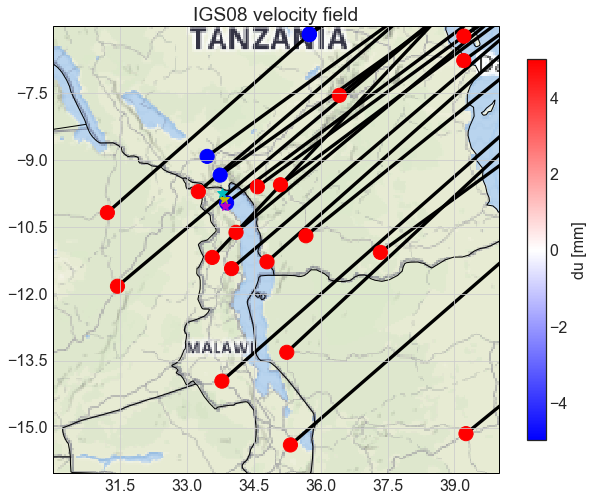

In [30]:
# Add more informative basemap, and Sentinel coverage
print('Number of Stations = ', df.shape[0])
fig, ax = plt.subplots(1,1,figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add mapbox tiles
# https://www.mapbox.com/api-documentation/#delete-icon-from-sprite
# Default professional & free!
map_id = 'high-contrast' #streets-satellite outdoors run-bike-hike pencil emerald high-contrast
map_id = 'emerald'
mytoken = 'pk.eyJ1Ijoic2NvdHR5aHEiLCJhIjoicjZVRzRrbyJ9.YqXIVvdJuiWUZSF1AjtA0A'
tiler = MapboxTiles(mytoken, map_id='mapbox.{}'.format(map_id))
ax.set_extent([30, 40, -6, -16]) #W E N S 
ax.add_image(tiler, 5) #Bigger number = higher resolution, longer to load... (8-9 needed for 2-3 degree grid)

sc = plt.scatter(df.lon, df.lat, c=df.up*1e3, s=200, 
                 norm=None,
                 vmin=-5,
                 vmax=5,
                 cmap=plt.cm.bwr, #linear scale 
                 #cmap=plt.cm.bwr, #symmetric scale
                 transform=ccrs.Geodetic(),
                 zorder=2,
                 )

# Plot seismic epicenters
plt.plot(*pSegment, 'y*', ms=10)
#plt.annotate('SEGMENT', pSegment, (1, -1), transform=ccrs.Geodetic(), fontweight='bold', va='top',zorder=10, textcoords='offset points')

plt.plot(*pNEIC, 'm*', ms=10)
#plt.annotate('NEIC', pNEIC, transform=ccrs.Geodetic(), fontweight='bold', ha='center', va='top', zorder=10)

plt.plot(*pCMT, 'c*', ms=10)
#plt.annotate('CMT', pCMT, transform=ccrs.Geodetic(), fontweight='bold', ha='center', va='top', zorder=10)

# Plot trench

# Could plot far-field subset or scale vectors close to EQ by 1/2...
plt.quiver(df.lon, df.lat, df.east, df.north, scale=0.1, transform=ccrs.PlateCarree(), color='k', zorder=1) # bigger arrows

cb = plt.colorbar(sc, orientation='vertical', shrink=0.7)
cb.set_label('du [mm]')
ax.coastlines('50m')
borders = cfeature.BORDERS
borders.scale='50m'
ax.add_feature(borders)
gl = ax.gridlines(draw_labels=True)
gl.xlabels_top = False
gl.ylabels_right = False

plt.title('IGS08 velocity field')

Number of Stations =  23


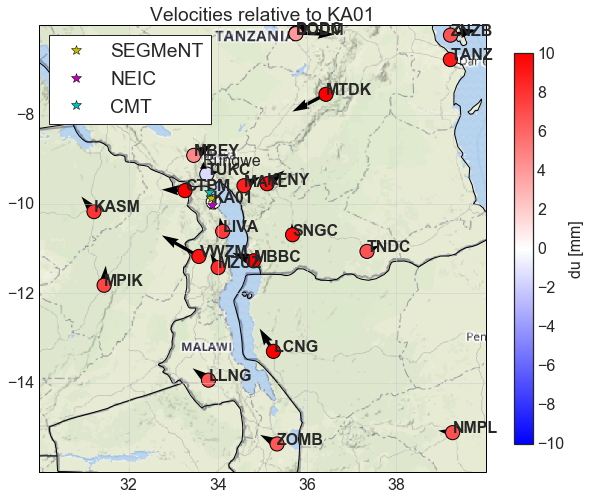

In [14]:
#Plot velocities relative to KA01, label stations
ref = df.query('site == "KA01"')
# Add more informative basemap, and Sentinel coverage
print('Number of Stations = ', df.shape[0])
fig, ax = plt.subplots(1,1,figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add mapbox tiles
# https://www.mapbox.com/api-documentation/#delete-icon-from-sprite
# Default professional & free!
map_id = 'high-contrast' #streets-satellite outdoors run-bike-hike pencil emerald high-contrast
map_id = 'emerald'
mytoken = 'pk.eyJ1Ijoic2NvdHR5aHEiLCJhIjoicjZVRzRrbyJ9.YqXIVvdJuiWUZSF1AjtA0A'
tiler = MapboxTiles(mytoken, map_id='mapbox.{}'.format(map_id))
ax.set_extent([30, 40, -6, -16]) #W E N S 
ax.add_image(tiler, 6) #Bigger number = higher resolution, longer to load... (8-9 needed for 2-3 degree grid)

sc = plt.scatter(df.lon.values, df.lat.values, c=(df.up.values-ref.up.values)*1e3, s=200, 
                 norm=None,
                 vmin=-10,
                 vmax=10,
                 cmap=plt.cm.bwr, #linear scale 
                 #cmap=plt.cm.bwr, #symmetric scale
                 transform=ccrs.Geodetic(),
                 zorder=2,
                 )

for i,row in df.iterrows():
    plt.text(row.lon, row.lat, row.site, transform=ccrs.Geodetic(), fontweight='bold')

# Plot seismic epicenters
plt.plot(*pSegment, 'y*', ms=10, label='SEGMeNT')
#plt.annotate('SEGMENT', pSegment, (1, -1), transform=ccrs.Geodetic(), fontweight='bold', va='top',zorder=10, textcoords='offset points')

plt.plot(*pNEIC, 'm*', ms=10, label='NEIC')
#plt.annotate('NEIC', pNEIC, transform=ccrs.Geodetic(), fontweight='bold', ha='center', va='top', zorder=10)

plt.plot(*pCMT, 'c*', ms=10, label='CMT')
#plt.annotate('CMT', pCMT, transform=ccrs.Geodetic(), fontweight='bold', ha='center', va='top', zorder=10)

# Volcanoes
plt.plot(33.668, -9.135, 'k^')#, label='Rungwe') #2953m 
plt.text(33.668, -9.135, 'Rungwe')
#plt.plot(33.554, -8.989, 'k^', label='Ngozi')
#plt.plot(33.792, -9.229, 'k^', label='Kyejo') #2176 

# Could plot far-field subset or scale vectors close to EQ by 1/2...
plt.quiver(df.lon.values, df.lat.values, df.east.values-ref.east.values, df.north-ref.north.values, scale=0.05, transform=ccrs.PlateCarree(), color='k', zorder=1) # bigger arrows

cb = plt.colorbar(sc, orientation='vertical', shrink=0.7)
cb.set_label('du [mm]')
ax.coastlines('50m')
borders = cfeature.BORDERS
borders.scale='50m'
ax.add_feature(borders)
gl = ax.gridlines(draw_labels=True)
gl.xlabels_top = False
gl.ylabels_right = False
plt.legend(loc='upper left', frameon=True)
plt.title('Velocities relative to KA01')

In [15]:
# Distances with cartopy
#from cartopy.geodesic import Geodesic
#geod = Geodesic() #default ellipsoid
#dutur = np.asarray(geod.inverse( (-70.769, -19.610), (-67.205542,-22.242005) )).T #distance and azimuths
# distance in meters, azimuth is degrees clockwise from north

In [16]:
df

,site,version,start_x,end_x,years,epochs,epochs_good,pairs,east,north,...,out_u,sig_e,sig_n,sig_u,nsteps,lat,lon,height,start_y,end_y
0,CTPM,MIDAS4,2013.1636,2016.5120,3.3484,1218,1218,1711,0.018787,0.016043,...,0.045,0.004193,0.003369,0.009150,0,-9.7013,33.2630,1285.533,2013-03-01,2016-07-06
1,DODC,MIDAS4,2009.3854,2010.6092,1.2238,80,80,80,0.025713,0.015767,...,0.112,0.001284,0.001891,0.003104,0,-6.1696,35.7483,1100.225,2009-05-21,2010-08-11
2,DODM,MIDAS4,2010.7242,2015.6879,4.9637,1728,1728,2807,0.023116,0.017213,...,0.048,0.002720,0.002633,0.009527,0,-6.1865,35.7482,1122.578,2010-09-22,2015-09-09
3,KA01,MIDAS4,2013.1061,2014.1903,1.0842,357,55,55,0.021392,0.015932,...,0.000,0.005864,0.002817,0.013095,0,-9.9541,33.8955,513.842,2013-02-08,2014-03-11
4,KASM,MIDAS4,2013.1718,2015.4470,2.2752,832,832,934,0.019983,0.017618,...,0.073,0.002958,0.002588,0.007866,0,-10.1716,31.2248,1365.564,2013-03-04,2015-06-13
5,KFNY,MIDAS4,2012.5640,2016.3970,3.8330,1118,1118,1507,0.023335,0.017405,...,0.078,0.002329,0.002293,0.005918,0,-9.5468,35.1025,1714.841,2012-07-25,2016-05-25
6,LCNG,MIDAS4,2013.5524,2015.2827,1.7303,198,173,173,0.019848,0.018478,...,0.035,0.001948,0.001664,0.005885,0,-13.3013,35.2436,1360.224,2013-07-21,2015-04-14
7,LIVA,MIDAS4,2013.1636,2016.3066,3.1430,1148,1148,1567,0.021061,0.017506,...,0.066,0.003108,0.002990,0.009921,0,-10.6137,34.1071,1359.543,2013-03-01,2016-04-22
8,LLNG,MIDAS4,2009.0541,2013.1116,4.0575,862,862,1309,0.019616,0.017262,...,0.081,0.002621,0.002008,0.005951,0,-13.9470,33.7895,1109.244,2009-01-20,2013-02-10
9,MATL,MIDAS4,2012.5503,2016.3723,3.8220,1294,1294,1929,0.023237,0.016952,...,0.165,0.003221,0.002720,0.011063,0,-9.5920,34.5847,2184.100,2012-07-20,2016-05-16


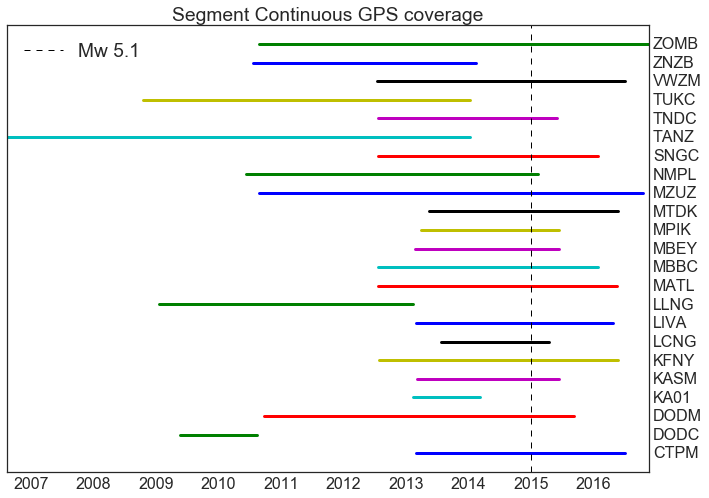

In [17]:
# Timeline of continuous GPS measurements
eq = pd.to_datetime('2014-12-31')

dfStations = df.copy()
fig,ax = plt.subplots(1,1,figsize=(11.5,8))
for i,row in df.iterrows():
    plt.plot([row.start_y, row.end_y], [i,i], lw=3)
plt.ylim(-1, len(df))
plt.title('Segment Continuous GPS coverage')
plt.axvline(eq, linestyle='dashed', color='k', label='Mw 5.1')
plt.legend(loc='upper left')
plt.yticks(df.index.values, df.site.values)
plt.tick_params(labelleft=False, labelright=True, bottom=True, top=True, right=True, left=True)

In [18]:
# Save all stations into shp file for plotting / viewing in google earth
import shapely

geometries = df.apply(lambda row: shapely.geometry.Point(row['lon'], row['lat']), axis=1)  
gf = gpd.GeoDataFrame(df.ix[:,['site','start_x', 'end_x']], crs='+init=epsg:4326', geometry=geometries)
gf.to_file('segment_gps.shp')

In [19]:
# Extract stations that cover 2014 eq
#gf = gpd.GeoDataFrame(df.ix[:,'site','start_x', 'end_x'], crs='')

In [20]:
# Plot LIVA timeseries
site = 'LIVA'
filename = gps.download_data(site)
df = gps.load_tenv3(filename)
#dfCh, dfEq = gps.load_steps(os.environ['UNGL_DATA'], station=site) #equipment changes or earthquakes
dfM = gps.load_midas(station=site)

LIVA already dowloaded... skipping


In [21]:
df.head()

,site,date,decyear,mjd,week,day,reflon,e0,east,n0,north,u0,up,ant,sig_e,sig_n,sig_u,corr_en,corr_eu,corr_nu
date,,,,,,,,,,,,,,,,,,,,
2013-03-01,LIVA,13MAR01,2013.1636,56352,1729,6,34.1,771,0.596834,-1173738,-0.547056,1359,0.541951,0.0,0.000566,0.000498,0.002361,0.055612,0.113076,0.234375
2013-03-02,LIVA,13MAR02,2013.1663,56353,1729,7,34.1,771,0.597600,-1173738,-0.544845,1359,0.543843,0.0,0.000565,0.000494,0.002348,0.085410,0.089944,0.249409
2013-03-03,LIVA,13MAR03,2013.1691,56354,1730,1,34.1,771,0.595147,-1173738,-0.544370,1359,0.548473,0.0,0.000563,0.000492,0.002404,0.087192,0.097886,0.262258
2013-03-04,LIVA,13MAR04,2013.1718,56355,1730,2,34.1,771,0.597779,-1173738,-0.542663,1359,0.560202,0.0,0.000578,0.000507,0.002414,0.064565,0.123664,0.240267
2013-03-05,LIVA,13MAR05,2013.1745,56356,1730,3,34.1,771,0.596426,-1173738,-0.542102,1359,0.546365,0.0,0.000569,0.000493,0.002405,0.075429,0.125510,0.245508


## MIDAS

In [22]:

print('East: {:.2f} mm/yr +/- {:.2f} mm/yr'.format(dfM.east.values[0]*1e3, dfM.err_e.values[0]*1e3))
print('North: {:.2f} mm/yr +/- {:.2f} mm/yr'.format(dfM.north.values[0]*1e3, dfM.err_n.values[0]*1e3))
print('Up: {:.2f} mm/yr +/- {:.2f} mm/yr'.format(dfM.up.values[0]*1e3, dfM.err_u.values[0]*1e3))

East: 21.06 mm/yr +/- 0.61 mm/yr
North: 17.51 mm/yr +/- 0.59 mm/yr
Up: 1.53 mm/yr +/- 1.95 mm/yr


## Simple Linear

In [23]:
for comp in ['east','north','up']:
    x = df.decyear
    y = df[comp]
    z,cov = np.polyfit(x, y, 1, cov=True)
    p = np.poly1d(z)
    #print(p)
    print('{}: {:.2f} mm/yr +/- ? mm/yr'.format(comp, p[1]*1e3))
    residuals = (p(x) - y)*1e3
    rmse = np.sqrt((np.sum(residuals**2) / residuals.size))
    print('rmse = {:.2f}'.format(rmse))
    
#all at once
dfLinear = gps.fit_linear(df)

east: 21.22 mm/yr +/- ? mm/yr
rmse = 2.68
north: 17.79 mm/yr +/- ? mm/yr
rmse = 2.86
up: 2.35 mm/yr +/- ? mm/yr
rmse = 9.19
2.34725468837
21.2010130523
17.7799289086


##  OSU

In [24]:
# create dataframe for storing results
sites = [site]
components = ['east','north','up']
iterables = [sites, components]
index = pd.MultiIndex.from_product(iterables, names=['site','comp'])

DF = pd.DataFrame(columns=['t0','xo', 'v', 'b','tj','s1','c1','t1','s2','c2','t2','rmse'], index=index, dtype='f4')
# assign result with:
#DF.loc[('UTUR','east'),:] = popt.append(rmse)

eq = pd.Timestamp('2014-12-31') #)23:46:47', tz='UTC')
tj = gps.decyear2date(eq.strftime('%y%b%d').upper(), True)

In [25]:
# Test and plot individual station
df = gps.cull_outliers(df, cols=components) #get rid of really bogus points before fit


for comp in components:
    print('fitting {}...'.format(comp))
    # Fit OSU Model
    t0 = df.decyear[0] # intial time [yr]
    x0 = df[comp][0] # initial position [m]
    v = (df[comp][-1] - df[comp][0]) / (df.decyear[-1] - df.decyear[0])  # trend [m/yr]
    b = 0.0  # step jump offset [m]
    #tj = #see cell above above
    s1 = s2 = c1 = c2 = 0.001 # fourier coefficients [m]
    T1 = 1 # fourier period 1 [yr]
    T2 = 0.5 #fourier period 2 [yr]
    guess = [t0,x0,v,b,tj,s1,c1,s2,c2,T1,T2]

    try:
        guess = [x0,v,b,s1,c1,s2,c2]
        fit,popt,rmse = gps.invert_osu(df['decyear'], df[comp], tj, guess)
        df['fit_'+comp] = fit
        # add fixed parameters back into popt
        popt = np.insert(popt, [0,3], [t0,tj])
        popt = np.append(popt, [T1,T2])
        DF.loc[(site,comp),:] = np.append(popt,rmse)
    except Exception as e:
        print(e)
        df['fit_'+comp] = gps.osu(df.decyear.values, *guess) #plot initial guess
        pass

east: Culled 0 points
north: Culled 0 points
up: Culled 5 points
fitting east...
too many values to unpack (expected 3)


TypeError: osu() missing 4 required positional arguments: 's2', 'c2', 'T1', and 'T2'

In [ ]:
pd.set_option('precision', 4) # Limit decimal places!
DF.head()
print('East: {:.2f} mm/yr +/- ? mm/yr'.format(DF.loc[(site,'east'),'v']*1e3))
print('North: {:.2f} mm/yr +/- ? mm/yr'.format(DF.loc[(site,'north'),'v']*1e3))
print('Up: {:.2f} mm/yr +/- ? mm/yr'.format(DF.loc[(site,'up'),'v']*1e3))

## Timeseries plot with fits

In [ ]:
dfFit = df.ix[:, ['fit_up','fit_north','fit_east']]
#gps.plot_all(df, dfSteps=dfEq, dfMidas=dfM, dfFit=dfFit)
gps.plot_all(df, dfMidas=dfM, dfFit=dfFit)#, dfExtra=dfLinear) 
plt.suptitle(site, y=0.93, fontsize=16)
plt.savefig('{}.pdf'.format(site), bbox_inches='tight')

## Notes:

* Seasonal signal hydrologic? Max uplift in November, max  subsidence in  July
* Plot estimated coseismic vertical offsets (OSU fit) from December 2014 event to estimate INSAR signal?
* run forward okada model w/ seismic moment tensors to predict InSAR observable displacement

* reprocess S1 InSAR data spanning EQ:
D142 * 12 day pairs
20141016
20141028
20141109
20141121
20141203
20141215
20141227
+
20150108
20150120

A101 * a few missing from ASF...
20141012
20141024
20141117
20141129
20141211
20141223
+
20150104
20150116
20150128


# Harvard CMT
  Date: 2014/12/31   Centroid Time: 19:47:38.0 GMT
  Lat=  -9.73  Lon=  33.79
  Depth= 12.0   Half duration= 1.0
  Centroid time minus hypocenter time:  2.0
  Moment Tensor: Expo=24  -0.723 -0.060 0.783 0.196 -0.026 0.009 
  Mw = 5.2    mb = 0.0    Ms = 5.1   Scalar Moment = 7.8e+23
  Fault plane:  strike=195    dip=46   slip=-68
  Fault plane:  strike=346    dip=48   slip=-111

In [32]:
# forward okada prediction
import vmodels as vm

In [28]:
#Mw = 5.1
M0 = 7.8e+23 ##dyne-cm (10−7 N⋅m)
Mw = (2/3.0) * (np.log10(M0) - 16.1) #Unitless
print('Moment Magnitude Mw = ', Mw)
l = 5e3 #estimated from aftershock distribution
w = 3e3
A = l*w
mu = 30e9
#M0 = mu*A*s #rigidity * Area * slip "Scalar Seismic Moment"
#print(M0)
s = (M0*1e-7) / (mu*A)
print('Estimated average slip = [m]', s)
d = mu * (s/np.sqrt(A))
print('Stress Drop = [MPa]', d*1e-6)
# http://www.ucl.ac.uk/EarthSci/people/sammonds/6%20Seismic%20moment.pdf
# some rules of thumb L/W ~2

Moment Magnitude Mw =  5.19472973513
Estimated average slip = [m] 0.17333333333333334
Stress Drop = [MPa] 1.34263422669


In [33]:
# UTM 36North EPSG:32636 coordinates
# one approach is to convert geocoded InSAR file to UTM w/ gdal & load that file!
# for now, disregard coordinates and just use abitrary meter grid

# copy parameters in order to show fault trace on plot - normal fault slip negative?
#depth: postive distance below surface to fault centroid [meters]
# NOTE slip always positive, negative rake defines normal motion
# here is a good description:
#http://www.opensha.org/glossary-strikeDipRake
params = dict(xcen=0, ycen=0,
                depth=12e3, length=l, width=w,
                slip=s, opening=0.0,
                strike=195.0, dip=46.0, rake=-68.0,
                nu=0.25)

'''
# Auxilary plane
paramsAux = dict(xcen=0, ycen=0,
                depth=12e3, length=l, width=w,
                slip=s, opening=0.0,
                strike=346.0, dip=48.0, rake=-111,
                nu=0.25)    
ux,uy,uz = vm.okada.forward(X,Y,**paramsAux)
vm.plot.plot_components(X,Y,ux,uy,uz,paramsAux)
'''

# Make grid NOTE: odd number so that center is symmetrical
n = 201
mid = int(n/2) #profile position
x = np.linspace(-25e3,25e3,n)
y = np.linspace(25e3,-25e3,n)
#x = np.linspace(-100e3,100e3,n) #to compare with Fialko's sic default
#y = np.linspace(100e3,-100e3,n) #need negative numbers to south!
X,Y = np.meshgrid(x,y)
extent=np.array([x.min(), x.max(), y.min(), y.max()])/1e3 #left, right, bottom, top

ux,uy,uz = vm.okada.forward(X,Y,**params)


TypeError: plot_fault() got an unexpected keyword argument 'xcen'

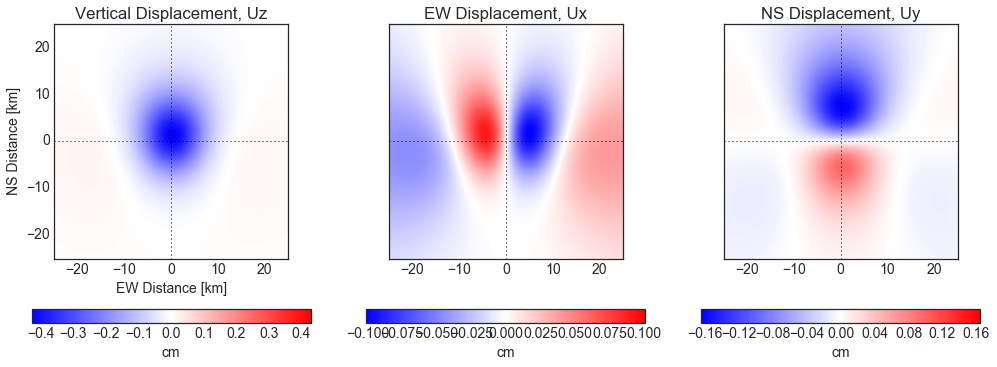

In [34]:
vm.plot.plot_components(X,Y,ux,uy,uz,params)

In [ ]:
# NOTE: instead of 3D fault plane, would be good to just show EW profile with flow vectors
# D152 los (41,-103) #inc head
# A101 los ( ,)
params['inc'] = 41.0
params['ald'] = -103.0
params['wavelength'] = 5.6 #cm
dataVec = np.dstack([ux, uy, uz])
cart2los = vm.util.get_cart2los(params['inc'],params['ald'])
los = -np.sum(dataVec * cart2los, axis=2)
vm.plot.plot_los(X, Y, ux, uy, uz, los, params, cmap='jet')

In [ ]:
vm.plot.plot_profile(x, y, 100, ux, uy, uz, los, axis=0, extent=None)

### NOTE:
model predicts  4mm  of subsidence. Each fringe is ~2.8 cm, so don't expect to see anything
what if indeed shallower (e.g. 6km depth)

In [ ]:
params = dict(xcen=0, ycen=0,
                depth=6e3, length=l, width=w,
                slip=s, opening=0.0,
                strike=195.0, dip=46.0, rake=-68.0,
                nu=0.25)

'''
# Auxilary plane
paramsAux = dict(xcen=0, ycen=0,
                depth=12e3, length=l, width=w,
                slip=s, opening=0.0,
                strike=346.0, dip=48.0, rake=-111,
                nu=0.25)    
ux,uy,uz = vm.okada.forward(X,Y,**paramsAux)
vm.plot.plot_components(X,Y,ux,uy,uz,paramsAux)
'''

ux,uy,uz = vm.okada.forward(X,Y,**params)

In [ ]:
vm.plot.plot_components(X,Y,ux,uy,uz,params)

In [ ]:
# NOTE: instead of 3D fault plane, would be good to just show EW profile with flow vectors
# D152 los (41,-103) #inc head
# A101 los ( ,)
params['inc'] = 41.0
params['ald'] = -103.0
params['wavelength'] = 5.6 #cm
dataVec = np.dstack([ux, uy, uz])
cart2los = vm.util.get_cart2los(params['inc'],params['ald'])
los = -np.sum(dataVec * cart2los, axis=2)
vm.plot.plot_los(X, Y, ux, uy, uz, los, params, cmap='jet')

In [ ]:
vm.plot.plot_profile(x, y, 100, ux, uy, uz, los, axis=0, extent=None)

In [ ]:
# Plot LOS Profiles for range of depths 10 - 4 km
plt.style.use('seaborn-white')
plt.rcParams['font.size'] = 16
print(params)
depths = np.arange(4,13,2)*1e3
plt.figure(figsize=(8,5))
for d in depths:
    params['depth'] = d
    ux,uy,uz = vm.okada.forward(X,Y,**params)
    dataVec = np.dstack([ux, uy, uz])
    cart2los = vm.util.get_cart2los(41.0, -103)
    los = -np.sum(dataVec * cart2los, axis=2)
    #plt.plot(x,uz[100],label=d)
    plt.plot(x*1e-3,los[100]*1e3,lw=2,label=d*1e-3)
    
plt.xlabel('Distance [km]')
plt.ylabel('LOS Displacement [mm]')
plt.legend(loc='lower left', title='Depth [km]')

{'xcen': 0, 'ycen': 0, 'depth': 2, 'strike': 30.0, 'dip': 70.0, 'length': 5, 'width': 3, 'rake': -45.0, 'slip': 0, 'opening': 1, 'nu': 0.25}


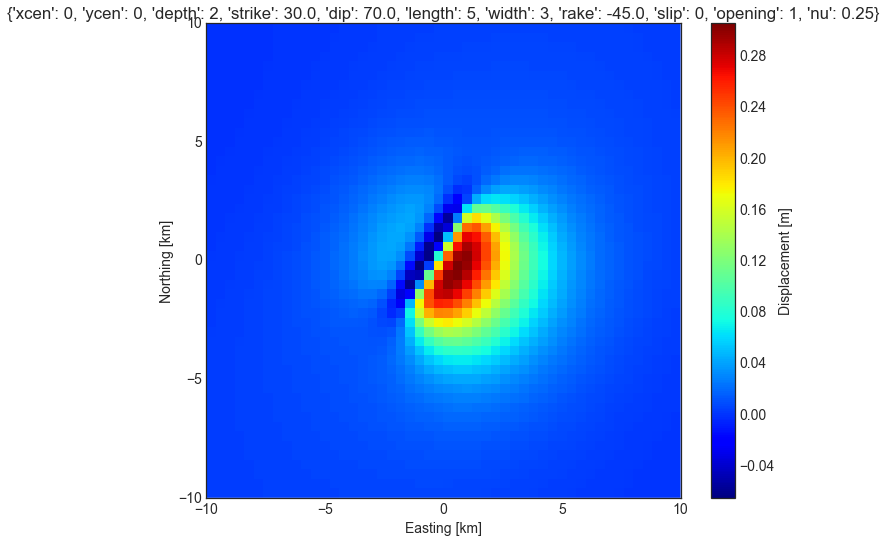

In [444]:
# Comparison with matlab example
#https://www.mathworks.com/matlabcentral/fileexchange/25982-okada--surface-deformation-due-to-a-finite-rectangular-source
#E,N,DEPTH,STRIKE,DIP,LENGTH,WIDTH,RAKE,SLIP,OPEN)
'''
%	Example:
%
%	   [E,N] = meshgrid(linspace(-10,10,50));
%	   [uE,uN,uZ] = okada85(E,N,2,30,70,5,3,-45,1,1,'plot');
%	   figure, surf(E,N,uN)
%
%	considers a 5x3 fault at depth 2, N30°-strike, 70°-dip, and unit dislocation
%	in all directions (reverse, senestral and open). Displacements are computed
%	on a regular grid from -10 to 10, and North displacements are plotted as a
%	surface.
'''
params = dict(xcen=0, ycen=0,
depth=2, strike=30.0, dip=70.0, 
length=5, width=3, rake=-45.0, #Double check equations for Opening U3. Verify mixed mode...
slip=0, opening=1, nu=0.25)
print(params)
# Make grid NOTE: odd number so that center is symmetrical
n = 50
mid = int(n/2) #profile position
e = np.linspace(-10,10,n)
n = e[::-1] #upper left index should be positive northing.. more intuitve
#n = e #matches matlab example
E,N = np.meshgrid(e,n)
extent=np.array([e.min(), e.max(), n.min(), n.max()]) #left, right, bottom, top

uE,uN,uZ = vm.okada.forward(E,N,**params)

plt.figure()
im = plt.imshow(uZ, extent=extent, interpolation='none', cmap='jet')
# resample grid for quiver plot
#nx = ny = 10
#plt.quiver(X[::nx, ::ny]/1e3, Y[::nx, ::ny]/1e3, ux[::nx, ::ny], uy[::nx, ::ny],
#        units='x', color='w')

plt.title(params.__str__())
plt.xlabel('Easting [km]')
plt.ylabel('Northing [km]')
cb = plt.colorbar(im)
cb.set_label('Displacement [m]')


In [438]:
import matplotlib.patches as patches

In [124]:
def plot_fault(X,Y,params):
    ''' Project fault plane onto surface - correct for depth to top of fault?'''
    # Project fault coordinates onto surface
    alpha = np.pi/2 - np.sin(np.deg2rad(params['strike']))
    beta = np.pi/2 - np.cos(np.deg2rad(params['strike']))
    dip = np.deg2rad(params['dip'])
    L = params['length']
    W = params['width']
    d = params['depth'] + np.sin(dip) * W / 2 #fault top edge

    x_fault = L/2 *np.cos(alpha)*np.array([-1,1,1,-1]) + np.sin(alpha)*np.cos(dip)*W/2*np.array([-1,-1,1,1])
    y_fault = L/2 *np.sin(alpha)*np.array([-1,1,1,-1]) + np.cos(alpha)*np.cos(dip)*W/2*np.array([1,1,-1,-1])
    z_fault = -d + np.sin(dip)*W*np.array([1,1,0,0])
    print(x_fault)
    print(y_fault)
    print(z_fault)
    
    fig,ax = plt.subplots(1,1,figsize=(8,8))
    verts = np.vstack([x_fault,y_fault]).T #vertices
    fault = patches.Polygon(verts, closed=True)
    ax.add_patch(fault)
    #ax.plot(alpha*L/2, beta*L/2, 'ko') # Strike direction
    ax.plot(x_fault[1], y_fault[1], 'ko') # Strike direction
    ax.set_xlim(X.min(), X.max())
    ax.set_ylim(Y.min(), Y.max())
    plt.grid(True)

{'xcen': 0, 'ycen': 0, 'depth': 2, 'strike': 30.0, 'dip': 70.0, 'length': 5, 'width': 3, 'rake': -45.0, 'slip': 1, 'opening': 1, 'nu': 0.25}
[-1.64879022  0.74833748  1.64879022 -0.74833748]
[-1.94799662  2.43991619  1.94799662 -2.43991619]
[-0.59046107 -0.59046107 -3.40953893 -3.40953893]


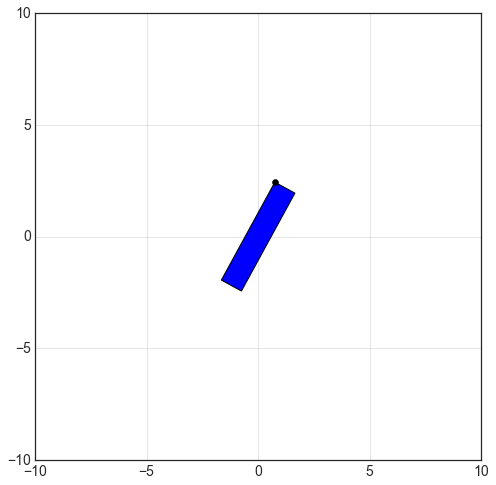

In [125]:
print(params)
plot_fault(X,Y,params)

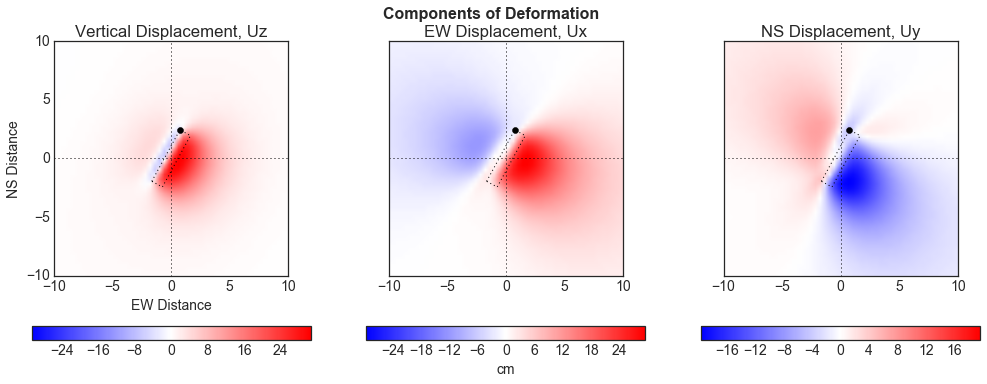

In [460]:
vm.plot.plot_components(E,N,uE*1e2,uN*1e2,uZ*1e2,params, plot_fault=True,clabel='cm')

In [446]:
vm.plot.plot_components

(-10.0, 10.0)

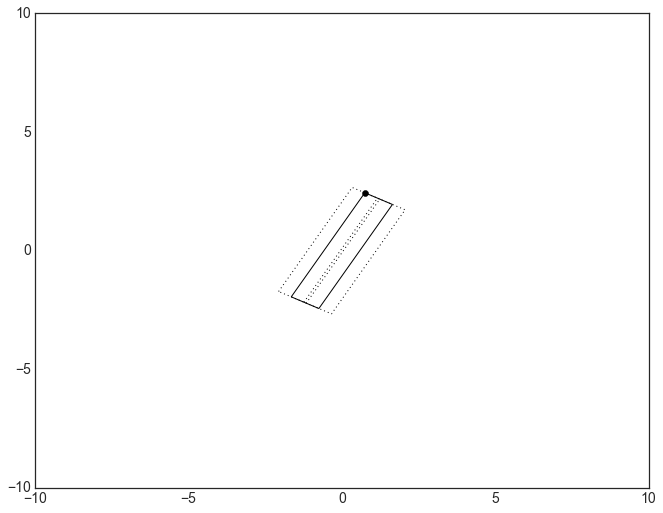

In [471]:
strike = np.deg2rad(params['strike'])
alpha = np.pi/2 - np.sin(strike)
dip = np.deg2rad(params['dip'])
rake = np.deg2rad(params['rake'])

L = params['length']
W = params['width']
d = params['depth'] + np.sin(dip) * W / 2 #fault top edge

x_fault = L/2 *np.cos(alpha)*np.array([-1,1,1,-1]) + np.sin(alpha)*np.cos(dip)*W/2*np.array([-1,-1,1,1])
y_fault = L/2 *np.sin(alpha)*np.array([-1,1,1,-1]) + np.cos(alpha)*np.cos(dip)*W/2*np.array([1,1,-1,-1])
z_fault = -d + np.sin(dip)*W*np.array([1,1,0,0])

fig,ax = plt.subplots(1,1)

verts = np.vstack([x_fault,y_fault]).T #vertices
fault = patches.Polygon(verts, closed=True, facecolor='none')
ax.add_patch(fault)
ax.plot(x_fault[1], y_fault[1], 'ko') # Strike direction

# Displaced fault poistion
U1 = np.cos(rake) * params['slip']
U2 = np.sin(rake) * params['slip']
U3 = params['opening']
ddx = U1*np.cos(alpha) - U2*np.sin(alpha)*np.cos(dip) + U3*np.sin(alpha)*np.sin(dip)
ddy = U1*np.sin(alpha) + U2*np.cos(alpha)*np.cos(dip) - U3*np.cos(alpha)*np.sin(dip)
ddz = U2*np.sin(dip) + U3*np.cos(dip)
verts_hw = np.vstack([x_fault + ddx/2, y_fault + ddy/2]).T #vertices #hanging wall motion
fault_hw = patches.Polygon(verts_hw, closed=True, linestyle='dotted', facecolor='none')
ax.add_patch(fault_hw)
verts_fw = np.vstack([x_fault - ddx/2, y_fault - ddy/2]).T #vertices FOOT wall motion
fault_fw = patches.Polygon(verts_fw, closed=True, linestyle='dotted', facecolor='none')
ax.add_patch(fault_fw)


ax.set_xlim(X.min(), X.max())
ax.set_ylim(Y.min(), Y.max())